In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import matplotlib.pyplot as plt
import dask

In [4]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filepath=None):
    ds = xr.open_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/ERA5/datasets/{filepath}surf_ds.zarr'))
    return ds

In [5]:
ds2018 = open_ds('2018_')
ds2019 = open_ds('2019_')
ds2020 = open_ds('2020_')
ds2021 = open_ds('2021_')
ds2022 = open_ds('2022_')
ds2023 = open_ds('')

In [41]:
ds_unsorted = xr.concat([ds2018, ds2019, ds2020, ds2021, ds2022, 
                         ds2023.isel(expver=0).sel(time=slice('2023-01', '2023-06'))], dim='time')
ds = ds_unsorted.sortby(ds_unsorted.latitude)

In [42]:
ds

<xarray.Dataset>
Dimensions:    (time: 37128, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-06-30T23:00:00
    expver     int32 1
Data variables:
    e          (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssro       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-08 19:47:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Create mask object

In [43]:
hfacc = ds.sst.where(ds.sst == ds.sst.notnull(), 999).where(ds.sst < 999, np.nan)

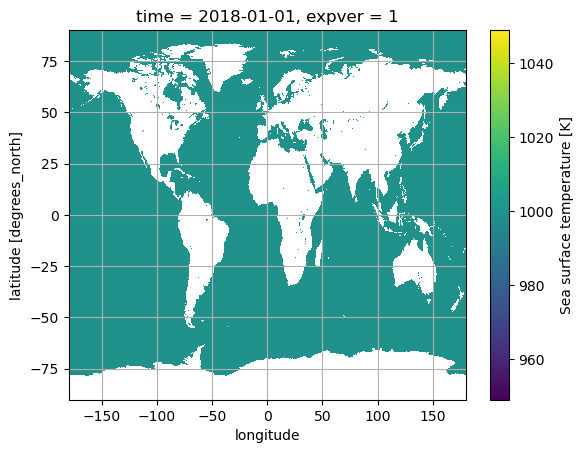

In [44]:
hfacc[0].plot()
plt.grid()

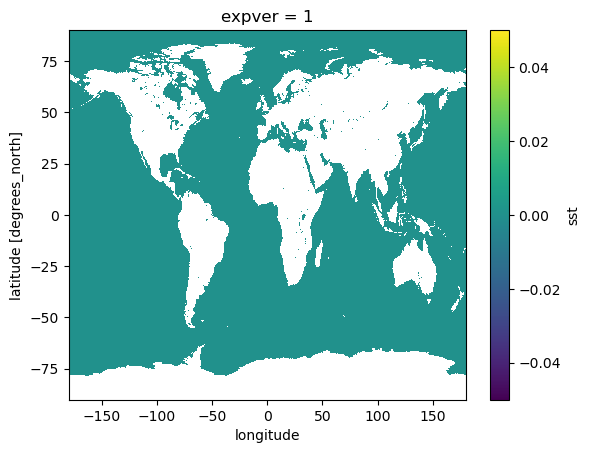

In [45]:
hfacc.std(dim='time').plot()

In [46]:
mask = hfacc[0]

In [47]:
mask

<xarray.DataArray 'sst' (latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    time       datetime64[ns] 2018-01-01
    expver     int32 1
Attributes:
    long_name:  Sea surface temperature
    units:      K

## Focus in on Gulf region

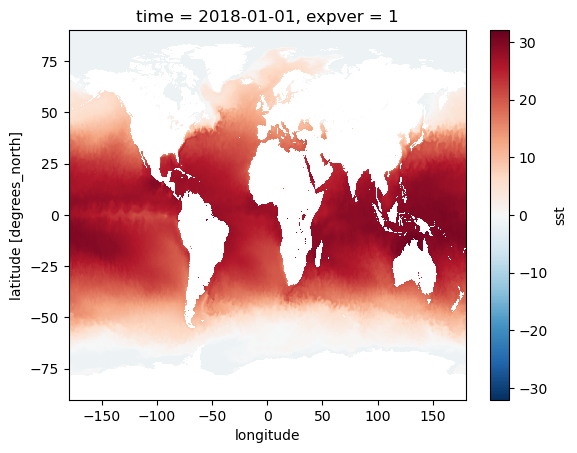

In [17]:
(ds.sst.isel(time=0) - 273.15).plot()

In [48]:
gulf = dict(longitude=slice(-100, 0), latitude=slice(8, 35))

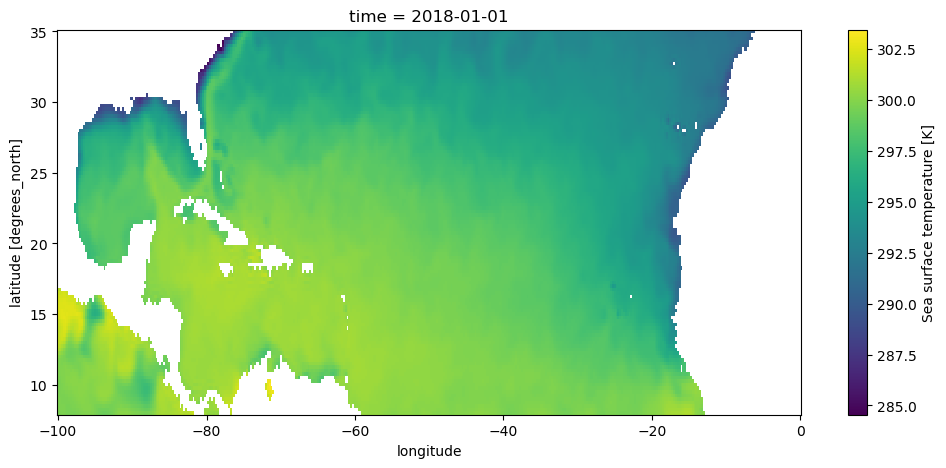

In [15]:
(ds.sst.isel(time=0).sel(**gulf)).plot(figsize=(12,5))

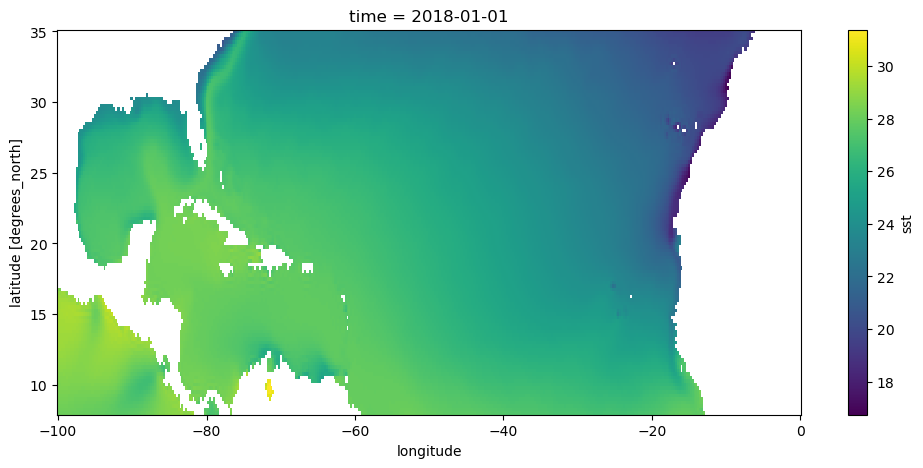

In [17]:
(ds.sst.sel(**gulf) - 273.15).mean('time').where(mask).plot(figsize=(12,5))

In [49]:
sst_trop = ds.sst.sel(**gulf) - 273.15

In [50]:
sst_trop

<xarray.DataArray 'sst' (time: 37128, latitude: 109, longitude: 401)>
dask.array<sub, shape=(37128, 109, 401), dtype=float32, chunksize=(15, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-06-30T23:00:00
    expver     int32 1

In [2]:
import cmocean

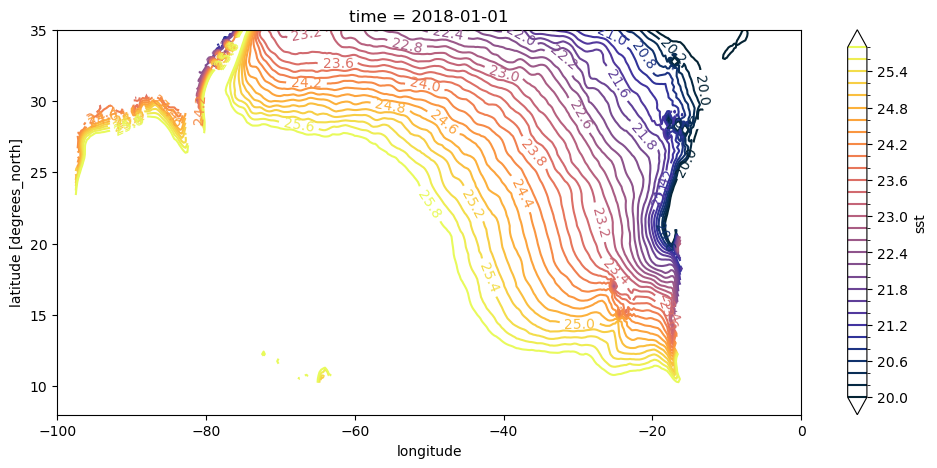

In [29]:
theta_levs = np.arange(20,26,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = sst_trop.where(mask).mean('time').where(mask).plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

Text(0.5, 1.0, 'Averaged 2018-2022 SST')

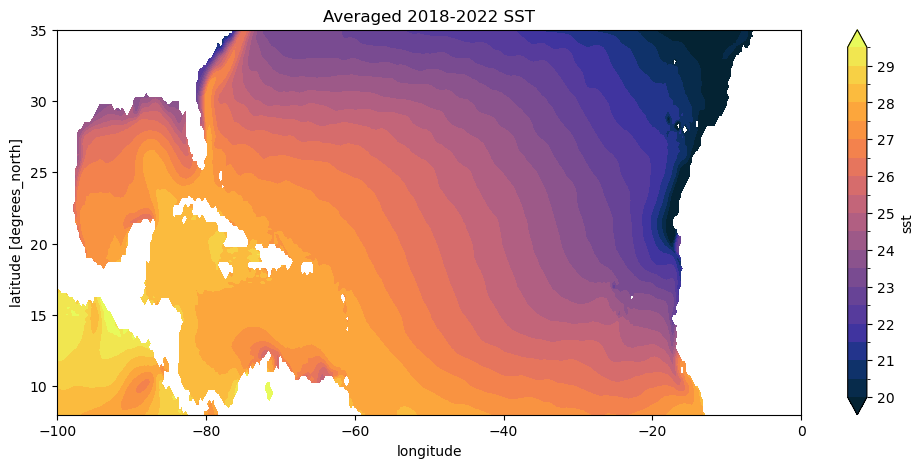

In [33]:
theta_levs = np.arange(20,30,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = sst_trop.where(mask).mean('time').where(mask).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
plt.title('Averaged 2018-2022 SST')

## Fixed threshold

In [51]:
#daily clim
clim = sst_trop.groupby('time.dayofyear').mean('time', keep_attrs=True, skipna=False)
clim_std = sst_trop.groupby('time.dayofyear').std('time', keep_attrs=True, skipna=False)
anom = sst_trop.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst_trop.groupby('time.month').mean()
mo_clim_std = sst_trop.groupby('time.month').std('time')
mo_anom = sst_trop.groupby('time.month') - mo_clim

In [52]:
clim

<xarray.DataArray 'sst' (dayofyear: 274, latitude: 109, longitude: 401)>
dask.array<transpose, shape=(274, 109, 401), dtype=float32, chunksize=(1, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    expver     (dayofyear) int32 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 268 269 270 271 272 273 274

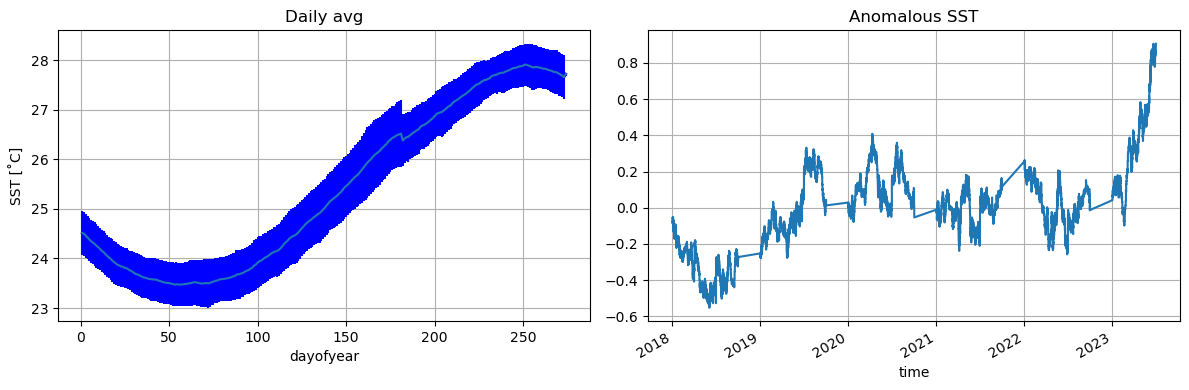

In [53]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

clim.mean(['latitude', 'longitude']).plot(ax=ax0, color='k', linewidth=2)
ax0.errorbar(clim.mean(['latitude', 'longitude']).dayofyear, clim.mean(['latitude', 'longitude']), 
             yerr=clim_std.mean(['latitude', 'longitude']), ecolor='blue')
ax0.set_title('Daily avg')
anom.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('Anomalous SST')
ax0.set_ylabel('SST [˚C]')
ax1.set_ylabel('')

ax0.grid()
ax1.grid()
plt.tight_layout();

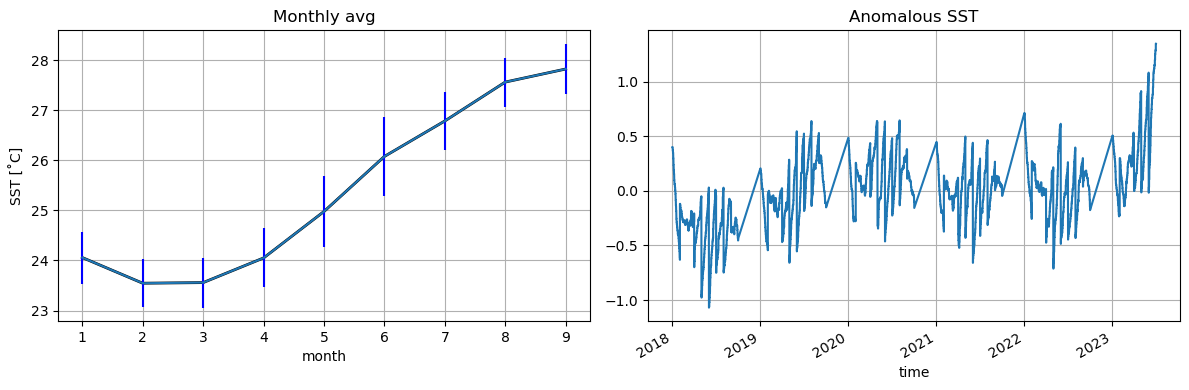

In [54]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

mo_clim.mean(['latitude', 'longitude']).plot(ax=ax0, color='k', linewidth=2)
ax0.errorbar(mo_clim.mean(['latitude', 'longitude']).month, mo_clim.mean(['latitude', 'longitude']), 
             yerr=mo_clim_std.mean(['latitude', 'longitude']), ecolor='blue')
ax0.set_title('Monthly avg')
mo_anom.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('Anomalous SST')
ax0.set_ylabel('SST [˚C]')
ax1.set_ylabel('')

ax0.grid()
ax1.grid()
plt.tight_layout();

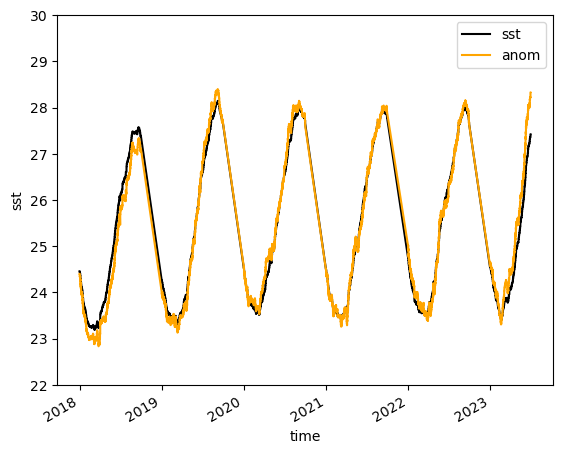

In [55]:
sst_trop.mean(['latitude', 'longitude']).plot(label='sst', color='k')
(sst_trop+anom).mean(['latitude', 'longitude']).plot(label='anom', color='orange')
plt.ylim(22,30)
plt.legend();

In [56]:
avg_sst_trop = sst_trop.mean(['latitude', 'longitude'])
avg_anom = (sst_trop+anom).mean(['latitude', 'longitude'])
hot = avg_anom.where(avg_anom > avg_sst_trop)
cold = avg_anom.where(avg_anom < avg_sst_trop)
hw = avg_anom.where(avg_anom > 27)
cs = avg_anom.where(avg_anom < 21)

In [57]:
hot

<xarray.DataArray 'sst' (time: 37128)>
dask.array<where, shape=(37128,), dtype=float32, chunksize=(15,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-06-30T23:00:00
    expver     (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    dayofyear  (time) int64 1 1 1 1 1 1 1 1 ... 181 181 181 181 181 181 181 181

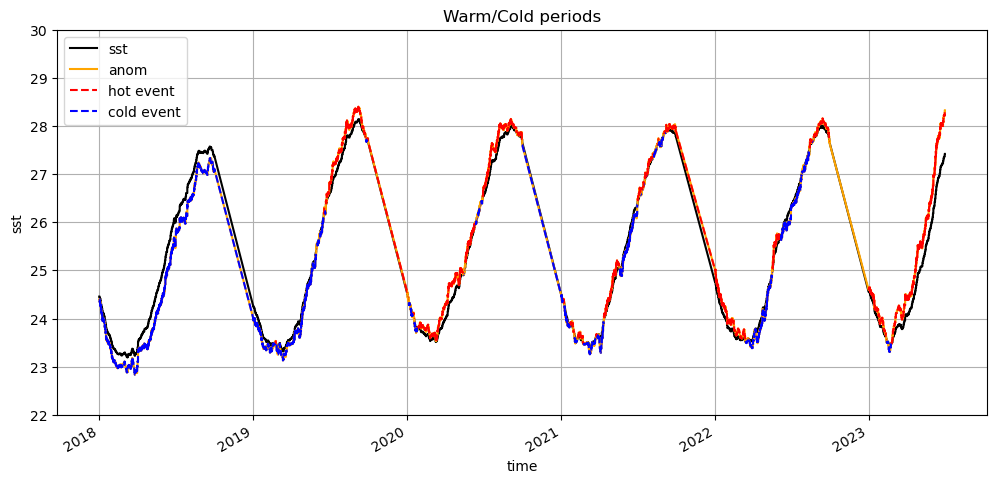

In [58]:
plt.figure(figsize=(12,5))

avg_sst_trop.plot(label='sst', color='k')
avg_anom.plot(label='anom', color='orange')
hot.plot(label='hot event', color='red', linestyle='dashed')
cold.plot(label='cold event', color='blue', linestyle='dashed')

plt.ylim(22,30)
plt.grid()
plt.legend()
plt.title('Warm/Cold periods');

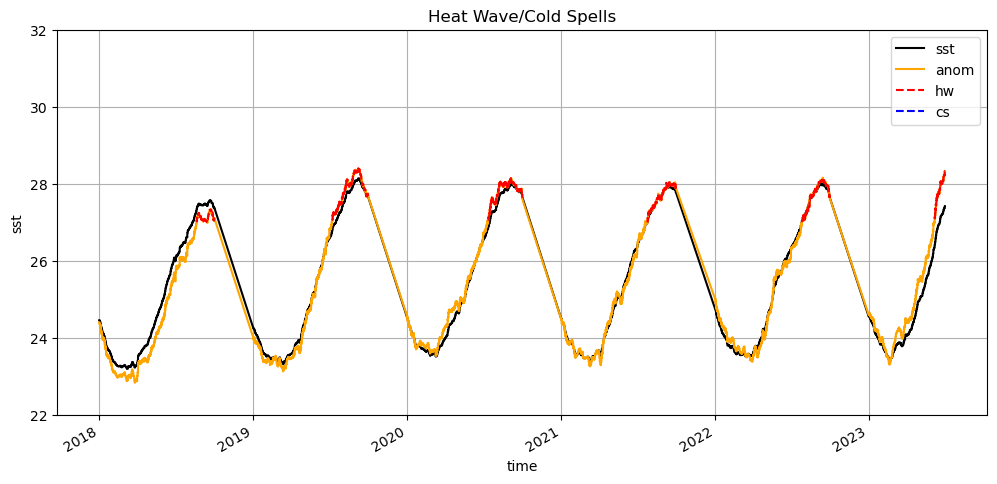

In [59]:
plt.figure(figsize=(12,5))

avg_sst_trop.plot(label='sst', color='k')
avg_anom.plot(label='anom', color='orange')
hw.plot(label='hw', color='red', linestyle='dashed')
cs.plot(label='cs', color='blue', linestyle='dashed')

plt.ylim(22,32)
plt.grid()
plt.legend()
plt.title('Heat Wave/Cold Spells');

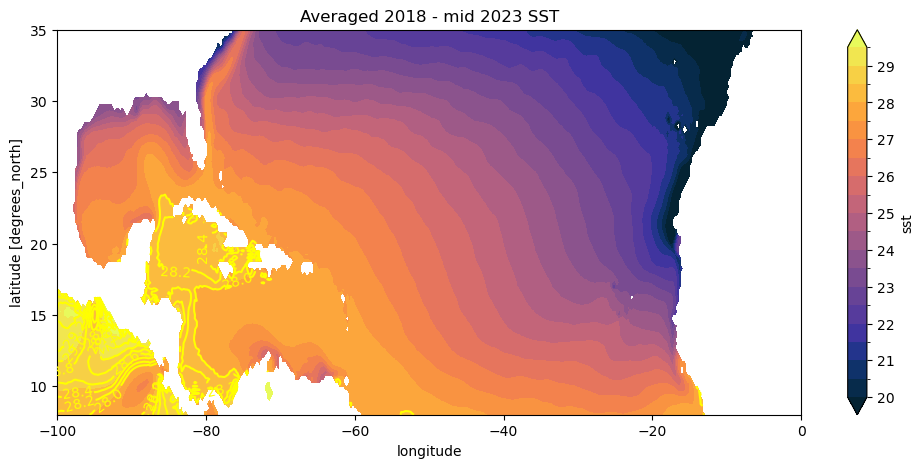

In [61]:
theta_levs = np.arange(20,30,0.5)

fig, ax = plt.subplots(figsize=(12,5))

C = sst_trop.mean('time').plot.contour(colors='yellow', levels=np.arange(28, 30, 0.2), ax=ax)
plt.clabel(C)

Cf = sst_trop.where(mask).mean('time').where(mask).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
plt.title('Averaged 2018 - mid 2023 SST');

# Temperature movie

In [77]:
upload_sst = sst_trop.drop('expver').chunk({'time':48})
upload_sst

<xarray.DataArray 'sst' (time: 37128, latitude: 109, longitude: 401)>
dask.array<rechunk-merge, shape=(37128, 109, 401), dtype=float32, chunksize=(48, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-06-30T23:00:00

In [2]:
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sst_trop_ds.zarr'))

In [3]:
ds_sst.sst

<xarray.DataArray 'sst' (time: 37128, latitude: 109, longitude: 401)>
dask.array<open_dataset-sst, shape=(37128, 109, 401), dtype=float32, chunksize=(48, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-06-30T23:00:00

In [4]:
#see what local dask is doing in the background 
from dask.distributed import LocalCluster, Client
import dask

with dask.config.set(**{"distributed.dashboard.link": "/user/{JUPYTERHUB_USER}/proxy/{port}/status"}):
    cluster = LocalCluster()
    client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/shanicetbailey/proxy/8787/status,
Dashboard: /user/shanicetbailey/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34817,Workers: 4
Dashboard: /user/shanicetbailey/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:35629,Total threads: 2
Dashboard: /user/shanicetbailey/proxy/38945/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:42409,


In [17]:
resampled = ds_sst.sst.resample(time='D').mean()

In [18]:
resampled

<xarray.DataArray 'sst' (time: 2007, latitude: 109, longitude: 401)>
dask.array<transpose, shape=(2007, 109, 401), dtype=float32, chunksize=(92, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-06-30

In [19]:
loaded_sst = resampled.load()

In [20]:
loaded_sst

<xarray.DataArray 'sst' (time: 2007, latitude: 109, longitude: 401)>
array([[[26.536535, 26.544924, 26.564497, ...,       nan,       nan,
               nan],
        [26.550262, 26.55124 , 26.561903, ...,       nan,       nan,
               nan],
        [26.56682 , 26.557604, 26.56334 , ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[26.620056, 26.62194 , 26.636337, ...,       nan,       nan,
               nan],
        [26.64055 , 26.632006, 26.632067, ...,       nan,       nan,
               nan],
        [26.658876, 26.63514 , 26.626379, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[29.317312, 29.242315, 29.233023, ...,       nan,       nan,
               nan],
        [29.42003 , 29.359415, 29.330465, ...,       nan,       nan,
               nan],
        [29.444712, 29.454271, 29.440485, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-06-30

In [10]:
from xmovie import Movie
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [21]:
import cmocean

def contour_surf(da, fig, tt, *args, **kwargs):
    
    ax = fig.subplots()
    theta_levs = np.arange(20,32,0.5)

    C = loaded_sst.isel(time=tt).plot.contour(colors='yellow', levels=[29], ax=ax)
    #ax.clabel(C)
    
    Cf = da.isel(time=tt).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
    
    return ax, Cf

2023-10-09 20:10:24,443 - distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)


(<Axes: title={'center': 'time = 2018-01-01'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <matplotlib.contour.QuadContourSet at 0x7fe6f07f70a0>)

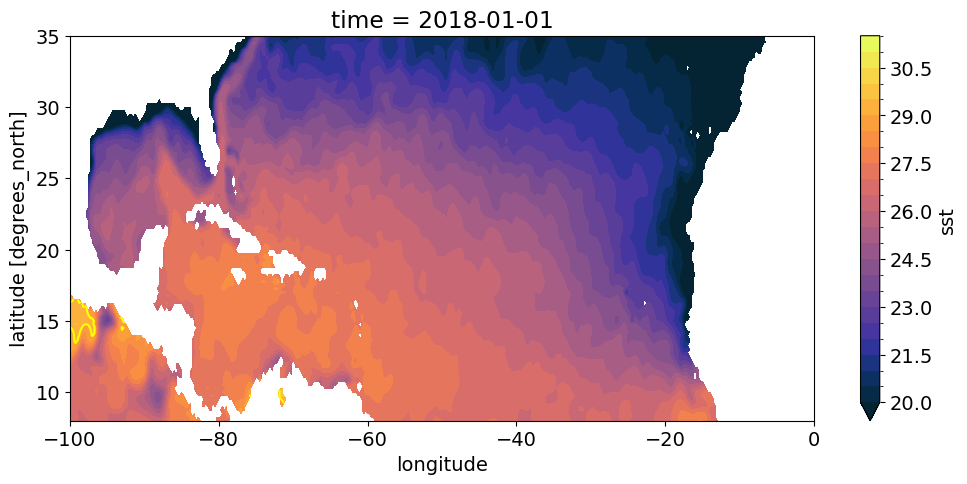

In [22]:
fig = plt.figure(figsize=(12, 5))

contour_surf(loaded_sst, fig, 0)

In [23]:
sst = Movie(loaded_sst, contour_surf, 
                   input_check=False)

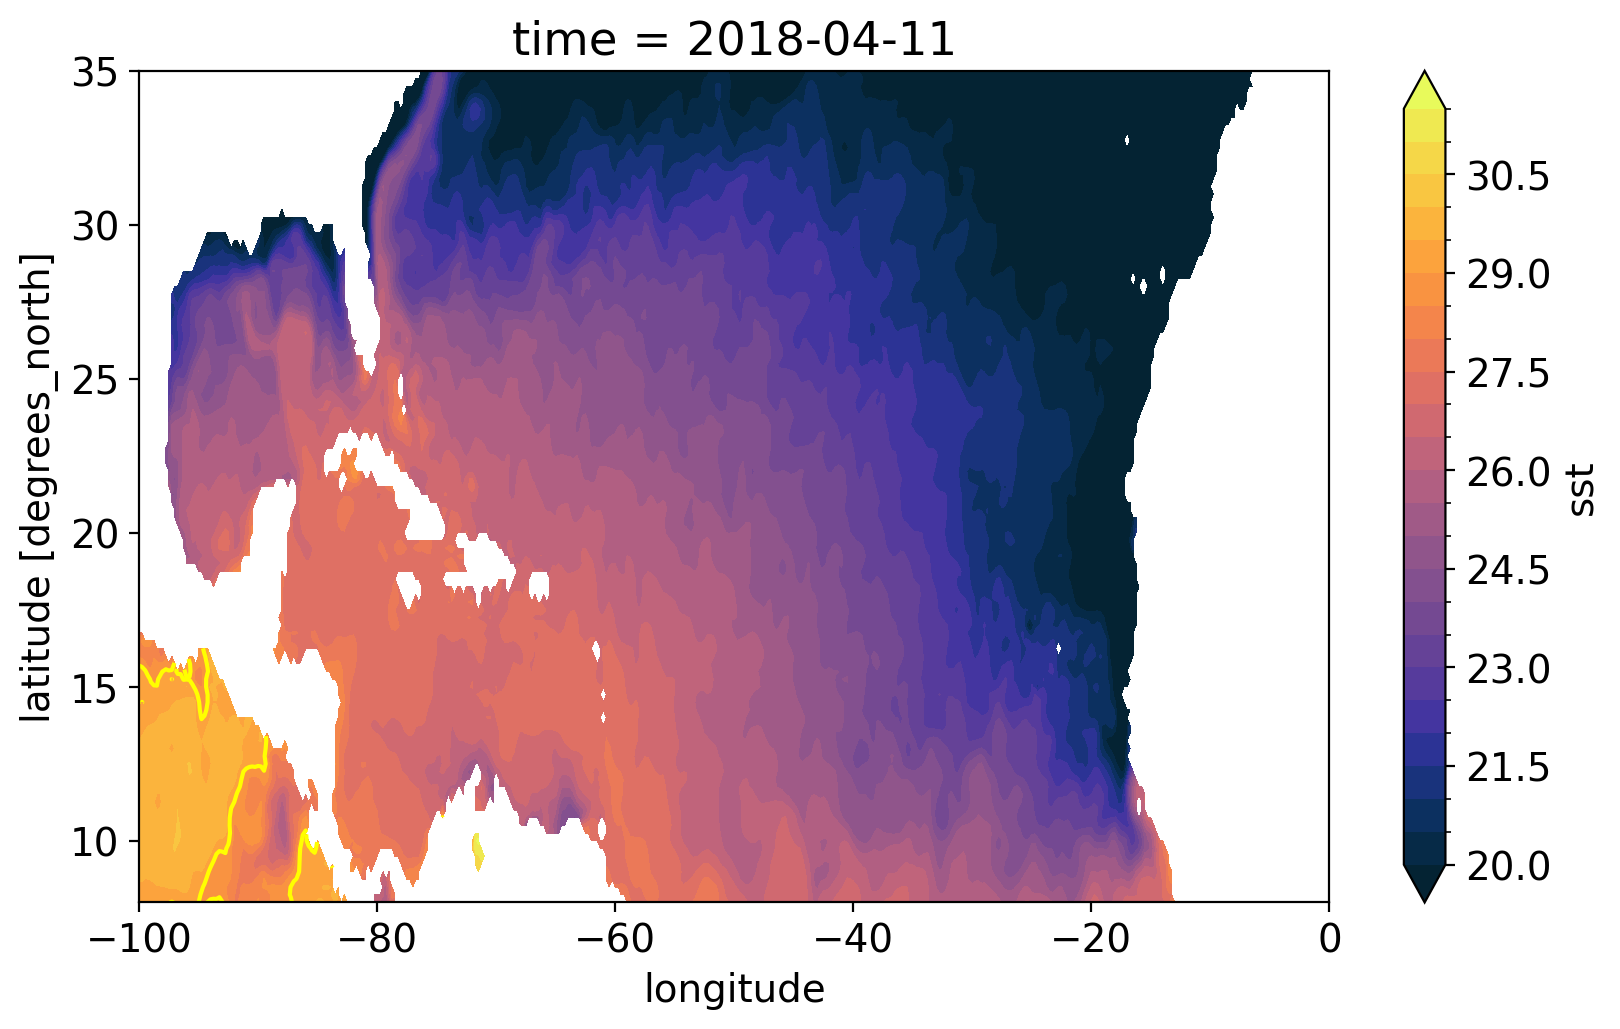

In [24]:
sst.preview(100)

In [25]:
#save sstmovie
sst.save('sst_daily.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/2007 [00:00<?, ?it/s]

2023-10-09 20:10:39,169 - distributed.utils_perf - WARNING - full garbage collections took 49% CPU time recently (threshold: 10%)
2023-10-09 20:10:39,633 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-10-09 20:10:40,109 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-10-09 20:10:40,584 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-10-09 20:10:41,077 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-10-09 20:10:41,548 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-10-09 20:10:41,999 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2023-10-09 20:10:42,455 - distributed.utils_perf - WARNING - full garbage collections took

Movie created at sst_daily.mp4


In [22]:
client.close()
cluster.close()